# Understanding all-cause mortality in the United States using Generalized
# Linear Models

This notebook uses generalized linear modeling (GLM) to understand
mortality in different demographic subgroups, and its variation over
time, in the United States.  The data are obtained from the U.S. Centers
for Disease Control (CDC).  See the `vital_stats_prep.py` script for more
information about the data, and to see the code used to assemble
the data analyzed here.

You must run the `vital_stats_prep.py` script to obtain the data used here.
before running this script.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


This is the path to the data file on your system.  You will need
to change this to match the path used in the `vital_stats_prep.py`
script.

In [2]:
pa = "/nfs/kshedden/cdc_mortality/final/pop_mort.csv"
df = pd.read_csv(pa)

All of the GLM's we will be using here use the logarithm as their
link function.  Therefore we will use log-transformed population
as an offset, so that mortality is expressed relative to population.

In [3]:
df.loc[:, "logpop"] = np.log(df.Population)

The counts are binned temporally by year, month and day of week,
e.g. Tuesdays in Novermber, 2014.  There may be either 4 or 5
occurances of any given week day in one month, so we want to adjust
for that.

In [4]:
df.loc[:, "ldc"] = np.log(df.DayCount)

Fit an initial model treating all counts as being independent.

In [5]:
fml = "Deaths ~ Age_group + Sex + C(Year) + C(Month) + C(DOW) + ldc"
m1 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), offset=df.logpop, data=df)
r1 = m1.fit(scale="X2")

Fit a model in which counts in the same year/month are independent.

In [6]:
df["yearmonth"] = 20*df.Year + df.Month
m2 = sm.GEE.from_formula(fml, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.logpop, cov_struct=sm.cov_struct.Independence(), data=df)
r2 = m2.fit()

Fit a model in which the age-specific mortality rates vary by sex.

In [7]:
fml3 = "Deaths ~ Age_group * Sex + C(Year) + C(Month) + C(DOW) + ldc"
m3 = sm.GEE.from_formula(fml3, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.logpop, cov_struct=sm.cov_struct.Independence(), data=df)
r3 = m3.fit()

Use a score test to compare the model with Age x Sex interactions to the model
without them.

In [8]:
print(m3.compare_score_test(r2))

{'statistic': 83.76717745828859, 'df': 17, 'p-value': 8.155376374219259e-11}


Check whether the seasonality patterns vary by sex.

In [9]:
fml4 = "Deaths ~ Age_group * Sex + C(Year) + C(Month) * Sex + C(DOW) + ldc"
m4 = sm.GEE.from_formula(fml4, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.logpop, cov_struct=sm.cov_struct.Independence(), data=df)
r4 = m4.fit()

Use a score test to compare the model with Month x Sex interactions to the model
without them.

In [10]:
print(m4.compare_score_test(r3))

{'statistic': 31.283730972372712, 'df': 11, 'p-value': 0.0009928393968789972}


Check whether the long term trend varies by sex.

In [11]:
fml5 = "Deaths ~ (Age_group + C(Year) + C(Month)) * Sex + C(DOW) + ldc"
m5 = sm.GEE.from_formula(fml5, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.logpop, cov_struct=sm.cov_struct.Independence(), data=df)
r5 = m5.fit()

Use a score test to compare the model with Year x Sex interactions to the model
without them.

In [12]:
print(m5.compare_score_test(r4))

{'statistic': 43.662676311404084, 'df': 6, 'p-value': 8.622543468117527e-08}


Plot the age group effects by sex

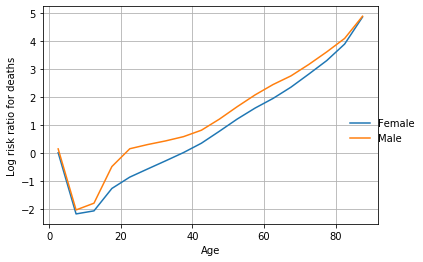

In [13]:
ages = ["%02d_%02d" % (a, a+4) for a in range(5, 90, 5)]
an = [a+2.5 for a in range(0, 90, 5)]
ages[-1] = "85_99"
pa = r5.params.to_dict()

xf = [0] + [pa['Age_group[T.%s]' % a] for a in ages]
xm = [0] + [pa['Age_group[T.%s]:Sex[T.Male]' % a] for a in ages]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
plt.plot(an, xf, label="Female")
plt.plot(an, xf + xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "center right")
leg.draw_frame(False)

Plot the male/female log risk ratio by age group

Text(0, 0.5, 'Log risk ratio for deaths')

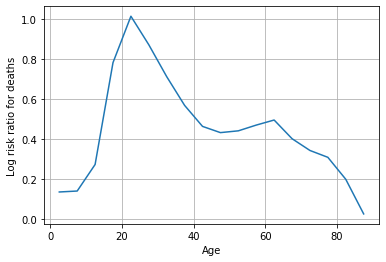

In [14]:
plt.grid(True)
plt.plot(an, xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Log risk ratio for deaths")

Plot the male/female log risk ratio by month

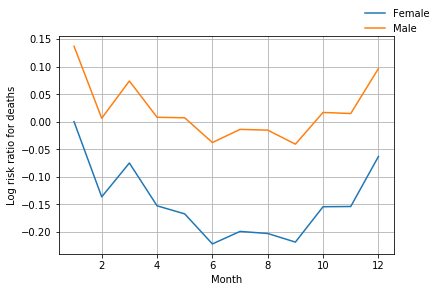

In [15]:
months = range(1, 13)
xf = [0] + [pa['C(Month)[T.%d]' % m] for m in range(2, 13)]
xm = [0] + [pa['C(Month)[T.%d]:Sex[T.Male]' % m] for m in range(2, 13)]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
plt.plot(months, xf, label="Female")
plt.plot(months, xf + xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb)
leg.draw_frame(False)

Plot the male/female log risk ratio for deaths by month

Text(0, 0.5, 'Log risk ratio for deaths')

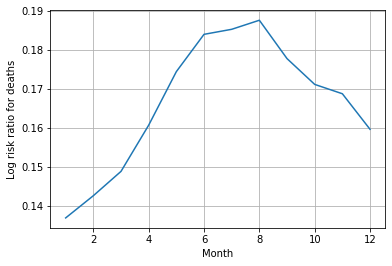

In [16]:
plt.grid(True)
plt.plot(months, xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Log risk ratio for deaths")